# Ajustement d'un Modèle Linéaire Généralisé

La méthode idoine pour ajuster des modèles linéaires généralisés au sein du paquet `statsmodels` est `GLM`. Les paramètres à spécifier sont :

- `endog` : `array-like`
    >Une variable de réponse endogène sous forme de tableau à une ou deux dimensions à l'image des arrays `numpy`. Les modèles de la famille binomiale prennent en charge un tableau à deux colonnes, où chaque observation est supposée être sous format  `[succès, échec]`.
    
- `exog` : `array-like`
    >Un tableau $n\times k$ où $n$ est le nombre d'observations et $k$ est le nombre de régresseurs. Un terme *intercept* n'est pas inclus par défaut et doit être spécifié (au moyen de `add_constant`). Les modèles définis au travers des formules comprennent une constante par construction.

- `family` : Instance de la classe `statsmodels.api.family`
    >Par défaut, correspond à la distribution gaussienne. Chaque constructeur de famille peut prendre en argument une fonction de lien (*i.e.* objet de type `statsmodels.api.families.family.<familyname>.Link`).
    >Les familles de distributions implémentées sont :
    
    - `Family(link, variance)` &nbsp;&nbsp; : &nbsp;&nbsp;Classe parente pour les familles exponentielles;
    - `Binomial([link])` &nbsp;&nbsp; : &nbsp;&nbsp; Distribution binomiale de la famille exponentielle;
    - `Gamma([link])` &nbsp;&nbsp; :&nbsp;&nbsp; Distribution Gamma de la famille exponentielle;
    - `Gaussian([link])` &nbsp;&nbsp; : &nbsp;&nbsp; Loi normale gaussienne;
    - `InverseGaussian([link])` &nbsp;&nbsp; : &nbsp;&nbsp; Loi normale inverse;
    - `NegativeBinomial([link, alpha])` &nbsp;&nbsp; :&nbsp;&nbsp; Loi binomiale négative;
    - `Poisson([link])` &nbsp;&nbsp; :&nbsp;&nbsp; Loi de Poisson de la famille exponentielle.
      
    >Les fonctions de liens prises en charge par une distribution peuvent être obtenues via `sm.families.family.<familyname>.links`. Les fonctions les plus courantes sont : `Log()`, `Logit()`, `probit()`, `identity()`...

    Seules ces combinaisons sont licites pour les familles et les fonctions de lien :
    
    |    Family    | `ident` | `log` | `logit` | `probit` | `cloglog` | `pow` | `opow` | `nbinom` | `loglog` | `logc` |
    |:------------:|:-----:|:---:|:-----:|:------:|:-------:|:---:|:----:|:------:|:------:|:----:|
    | Gaussienne     | x     | x   | x     | x      | x       | x   | x    | x      | x      |      |
    | Inv-Gaussienne | x     | x   |       |        |         | x   |      |        |        |      |
    | Binomiale     | x     | x   | x     | x      | x       | x   | x    |        | x      | x    |
    | Poisson      | x     | x   |       |        |         | x   |      |        |        |      |
    | Binomiale Négative | x     | x   |       |        |         | x   |      | x      |        |      |
    | Gamma        | x     | x   |       |        |         | x   |      |        |        |      |
    | Tweedie      | x     | x   |       |        |         | x   |      |        |        |      |

&nbsp;&nbsp;
- `offset` : `array_like` ou `None`
    >Un décalage ou *offset* à ajouter au modèle. Auquel cas, doit être un array dont la longueur est égale au nombre de lignes `exog`. 

- `exposure` : `array_like` ou `None`
    >Une variable d'exposition ou *exposure*, qui indique combien de temps a duré l’exposition ou le nombre de
fois où l’événement pourrait avoir eu lieu. Le cas échéant, `Log(exposure)` sera ajouté à la prédiction linéaire du modèle. Doit correspondre à un array de même longueur que `endog`.

```{admonition} Attention
:class: warning
La variable d'exposition n'est valide uniquement lorsque la fonction de lien est logarithmique!
```

- `freq_weights` : `array_like`
    >Un tableau à une dimension définissant les poids des fréquences des observations. À défaut de valeur, l'algorithme remplace cet argument par un array constitué de $1$ et de longueur identique à celle de la variable `endog`. Les poids des fréquences produisent les mêmes résultats que la répétition des observations au nombre des fréquences. Les pondérations de fréquence maintiennent le nombre d'observations cohérent, mais les degrés de liberté changent pour refléter les nouveaux poids.

- `var_weights` : `array_like`
    >Un tableau à une dimension déterminant les poids des variances. À défaut de valeur, l'algorithme remplace cet argument par un array constitué de $1$ et de longueur identique à celle de la variable `endog`. Les poids des variances sont utilisés lorsque `endog` représente une moyenne. Cela repose sur l'hypothèse que l'inverse de la variance est proportionnel au poids - une observation jugée plus crédible devrait avoir moins de variance et donc avoir plus de poids.

- `missing` : `str`
    >Les options disponibles sont `none`, `drop`, et `raise`. Si `none`, aucune vérification des valeurs `nan` n'est effectuée. `drop` fait que toutes les observations avec des `nan` sont abandonnées. `raise` signale une erreur. La valeur par défaut est `none`.

On commence par charger les paquets nécessaires, entre autres `matplotlib.pyplot` pour le traçage, `numpy` pour la manipulation des matrices et vecteurs et la génération aléatoire, ainsi que `pandas` pour le stockage des données.

In [2]:
# Affichage avec la bibliothèque graphique intégrée à Notebook
%matplotlib inline

import numpy as np
import statsmodels.api as sm
from scipy import stats
from matplotlib import pyplot as plt

plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

## GLM avec Réponse Binomiale

Dans un premier temps, on commence par ajuster un modèle linéaire généralisé à une variable expliquée binomiale (binaire).

Pour ce faire, on invoque le jeu de données **Star98**, concernent les résultats du programme STAR mis en place par l'instance pédagogique de California lors de 1998. Les données mesurent les tests standardisés du département californien de l'éducation qui a exigé l'évaluation des élèves de la 2ème à la 11ème année par le test Stanford 9 sur une variété de sujets. Ce jeu de données compore 303 enregistrements. La variable de réponse représente le nombre d'élèves de 9ème année ayant obtenu un score supérieur à la valeur médiane nationale à l'examen de mathématiques.

In [3]:
print(sm.datasets.star98.NOTE)

::

    Number of Observations - 303 (counties in California).

    Number of Variables - 13 and 8 interaction terms.

    Definition of variables names::

        NABOVE   - Total number of students above the national median for the
                   math section.
        NBELOW   - Total number of students below the national median for the
                   math section.
        LOWINC   - Percentage of low income students
        PERASIAN - Percentage of Asian student
        PERBLACK - Percentage of black students
        PERHISP  - Percentage of Hispanic students
        PERMINTE - Percentage of minority teachers
        AVYRSEXP - Sum of teachers' years in educational service divided by the
                number of teachers.
        AVSALK   - Total salary budget including benefits divided by the number
                   of full-time teachers (in thousands)
        PERSPENK - Per-pupil spending (in thousands)
        PTRATIO  - Pupil-teacher ratio.
        PCTAF    - Percenta

On importe d'emblée le jeu de données, et on ajoute un terme constant aux variables expliquées exogènes :

In [4]:
data = sm.datasets.star98.load()
data.exog = sm.add_constant(data.exog, prepend=False)

La variable de réponse correspond au couple $\rm{[Succès :}$ `NABOVE` $\rm{,Échec :}$ `NBELOW` $]$.

In [5]:
print(data.endog.head())

   NABOVE  NBELOW
0   452.0   355.0
1   144.0    40.0
2   337.0   234.0
3   395.0   178.0
4     8.0    57.0


Les variables indépendantes comportent toutes les autres variables décrites ci-dessus, ainsi que les termes d'interaction :

In [6]:
print(data.exog.head())

     LOWINC   PERASIAN   PERBLACK    PERHISP  PERMINTE  AVYRSEXP    AVSALK  \
0  34.39730  23.299300  14.235280  11.411120  15.91837  14.70646  59.15732   
1  17.36507  29.328380   8.234897   9.314884  13.63636  16.08324  59.50397   
2  32.64324   9.226386  42.406310  13.543720  28.83436  14.59559  60.56992   
3  11.90953  13.883090   3.796973  11.443110  11.11111  14.38939  58.33411   
4  36.88889  12.187500  76.875000   7.604167  43.58974  13.90568  63.15364   

   PERSPENK   PTRATIO     PCTAF  ...   PCTYRRND  PERMINTE_AVYRSEXP  \
0  4.445207  21.71025  57.03276  ...  22.222220         234.102872   
1  5.267598  20.44278  64.62264  ...   0.000000         219.316851   
2  5.482922  18.95419  53.94191  ...   0.000000         420.854496   
3  4.165093  21.63539  49.06103  ...   7.142857         159.882095   
4  4.324902  18.77984  52.38095  ...   0.000000         606.144976   

   PERMINTE_AVSAL  AVYRSEXP_AVSAL  PERSPEN_PTRATIO  PERSPEN_PCTAF  \
0       941.68811        869.9948        

À présent, on ajuste un modèle linéaire généralisé, en précisant la loi binomiale comme distribution de la réponse. Après, on affiche le résultat :

In [7]:
glm_binom = sm.GLM(data.endog, data.exog, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     ['NABOVE', 'NBELOW']   No. Observations:                  303
Model:                              GLM   Df Residuals:                      282
Model Family:                  Binomial   Df Model:                           20
Link Function:                    Logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -2998.6
Date:                  Thu, 05 Jan 2023   Deviance:                       4078.8
Time:                          15:45:34   Pearson chi2:                 4.05e+03
No. Iterations:                       5   Pseudo R-squ. (CS):              1.000
Covariance Type:              nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
LOWINC

Le nombre d'épreuves binomiales (en incorporant les fréquences pour chaque observations) est :

In [8]:
print("Nombre total d'épreuves :",  data.endog.iloc[:, 0].sum())

Nombre total d'épreuves : 108418.0


Les valeurs de la statistique de Student pour les test élémentaires d'influence de chaque variable explicatives peuvent être récupérés au travers de :

In [9]:
print(res.tvalues)

LOWINC                    -38.749083
PERASIAN                   16.504736
PERBLACK                  -25.182189
PERHISP                   -32.817913
PERMINTE                    8.498271
AVYRSEXP                    4.212479
AVSALK                      5.774998
PERSPENK                   -6.161911
PTRATIO                    -5.453217
PCTAF                      -5.168654
PCTCHRT                     3.921200
PCTYRRND                  -15.878260
PERMINTE_AVYRSEXP          -7.390931
PERMINTE_AVSAL             -8.449639
AVYRSEXP_AVSAL             -4.059162
PERSPEN_PTRATIO             6.321099
PERSPEN_PCTAF               6.574347
PTRATIO_PCTAF               5.362290
PERMINTE_AVYRSEXP_AVSAL     7.428064
PERSPEN_PTRATIO_PCTAF      -6.445137
const                       1.913012
dtype: float64


Il s'avère que toutes les réalisations de la statistique du test de Student sont toutes significativement supérieures à $0$, les variables explicatives ont ainsi toutes un impact sur la variable de réponse.

Pour confirmer ce constat, nous fixons toutes les variables explicatives à une constante égale à leur moyenne et on varie la variable `LOWINC` (en première colonne) dénotant le pourcentage des étudiants à faibles revenus pour évaluer son influence sur le succès dans l'examen national de mathématiques. 

La méthode `scoreatpercentile()` de `stats` permet de calculer le nombre d'unités inférieurs à un quantile d'ordre passé en paramètre.  

In [10]:
m = data.exog.mean(axis=0)
m25 = m.copy()
m25.iloc[0] = stats.scoreatpercentile(data.exog.iloc[:,0], 25)
m75 = m.copy()
m75.iloc[0] = stats.scoreatpercentile(data.exog.iloc[:,0], 75)

L'intervalle interquartile pour le pourcentage des étudiants à faibles revenus est donc :

In [11]:
resp_25 = res.predict(m25)
resp_75 = res.predict(m75)
diff = resp_75 - resp_25
print("%2.4f%%" % (diff*100))

-11.8753%


Ensuite, on représente les résultats ainsi générés dans des tracés.

In [13]:
# Nombre d'observations
n = res.nobs
# Valeurs observées de la variable expliquée NABOVE+NBELOW/2
y = data.endog.iloc[:,0]/data.endog.sum(1)
# Valeurs ajustées
yhat = res.mu

La fonction `abline_plot` permet de tracer des droites d'ajustement ou de régression à un nuage de points.

Text(0.5, 0, 'Valeurs Ajustées')

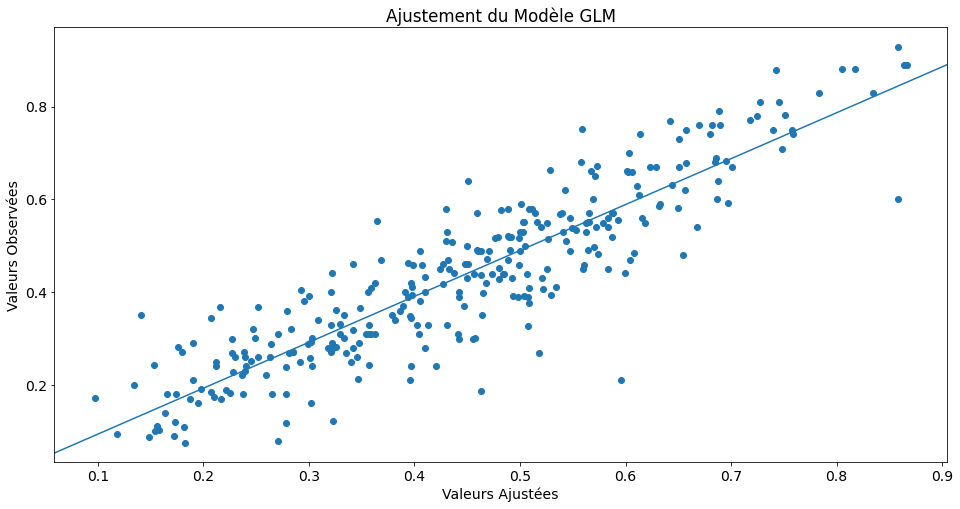

In [14]:
from statsmodels.graphics.api import abline_plot

fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)

ax.set_title('Ajustement du Modèle GLM')
ax.set_ylabel('Valeurs Observées')
ax.set_xlabel('Valeurs Ajustées')


Text(0.5, 0, 'Valeurs Ajustées')

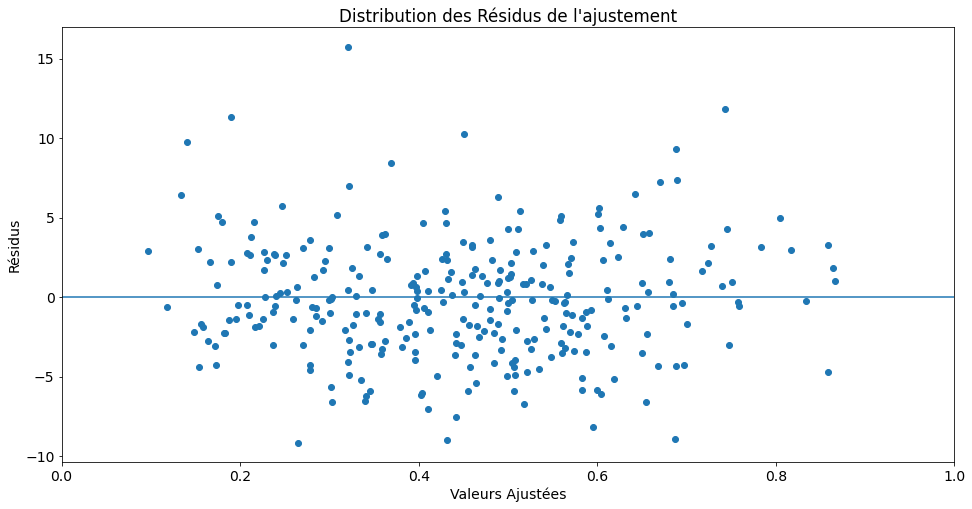

In [15]:
fig, ax = plt.subplots()

ax.scatter(yhat, res.resid_pearson)
ax.hlines(0, 0, 1)
ax.set_xlim(0, 1)
ax.set_title("Distribution des Résidus de l'ajustement")
ax.set_ylabel('Résidus')
ax.set_xlabel('Valeurs Ajustées')

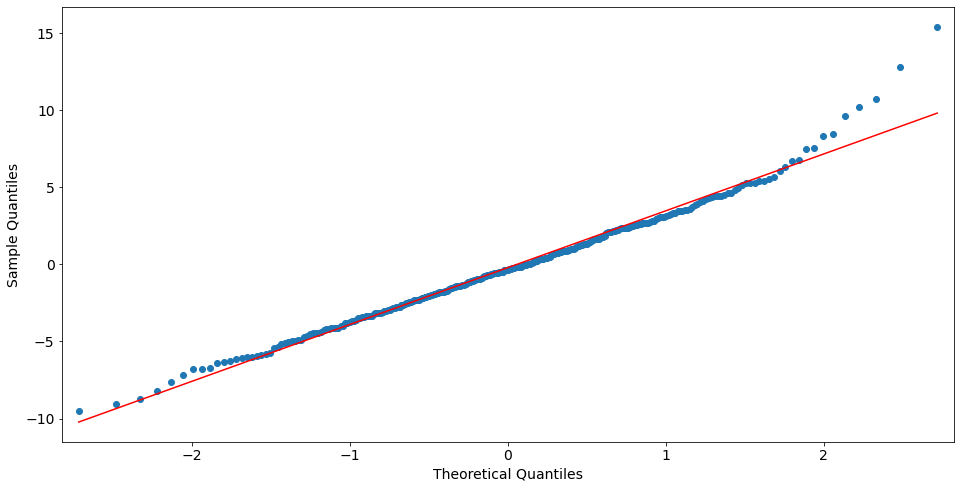

In [22]:
from statsmodels import graphics
graphics.gofplots.qqplot(res.resid_deviance.copy(), line='r')
plt.show()

## GLM avec Réponse Gaussienne

On génére $100$ observations d'un modèle linéaire généralisé $\ln(y_i)=\exp(-0.03x_i+0.0001x_i^2-1)+\varepsilon_i$, et on essaie d'adapter un modèle linéaire généralisé dessus, en précisant une distribution gaussienne à la réponse avec une fonction de lien logarithmique $\log$.

In [19]:
n = 100
x = np.arange(n)
np.random.seed(54321)
X = np.column_stack((x,x**2))
X = sm.add_constant(X, prepend=False)
lny = np.exp(-(.03*x + .0001*x**2 - 1.0)) + .001 * np.random.rand(n)

In [21]:
gauss = sm.GLM(lny, X, family=sm.families.Gaussian(sm.families.links.log()))
resultats = gauss.fit()
print(resultats.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Gaussian   Df Model:                            2
Link Function:                    log   Scale:                      1.0531e-07
Method:                          IRLS   Log-Likelihood:                 662.92
Date:                Thu, 05 Jan 2023   Deviance:                   1.0215e-05
Time:                        16:18:42   Pearson chi2:                 1.02e-05
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0300    5.6e-06  -5361.316      0.0

```{admonition} Conclusion
:class: tip
Le pseudo-coefficient de détermination de Cox & Snell $R_{\text{CS}}^{2}=1-\left({\frac {L_{0}}{L_{M}}}\right)^{2/n}$, correspondant à l'équivalent du coefficient de détermination ordinaire pour les GLMs est égal à $1$, confirmant le modèle théorique ci-dessus.
```